# Lab 3 MA course in Artificial Intelligence 2020/2021



In [1]:
!rm -r AI2020
!git clone https://github.com/UmbertoJr/AI2020.git

Cloning into 'AI2020'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 476 (delta 45), reused 51 (delta 22), pack-reused 399
Receiving objects: 100% (476/476), 1.59 MiB | 19.90 MiB/s, done.
Resolving deltas: 100% (291/291), done.


# Iterated Local Search for the Travelling Salesman Problem

Let's read the standard TSP instance called 'd198.tsp'

name: d198
nPoints: 198
best_sol: 15780.0


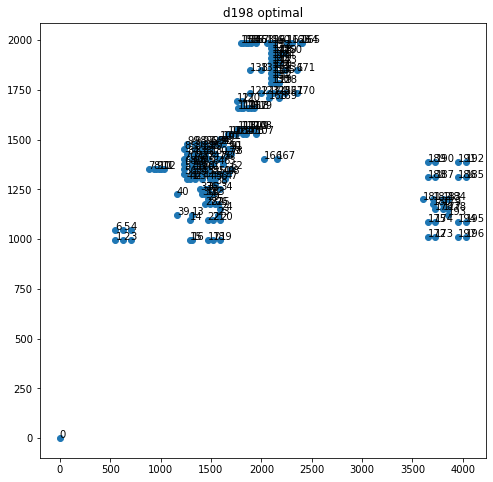

In [2]:
from AI2020.IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'd198.tsp') 
ic.print_info()
ic.plot_data()

## 2-opt

&nbsp;

Here is an example of how to use our black-box 2-opt implementation. As you saw in ["Introduction to the TSP"](https://colab.research.google.com/github/UmbertoJr/AI2020/blob/master/introduction_to_the_TSP.ipynb#scrollTo=4aGR4Nus83wa), the meta-heuristics must respect the input and output format shown!

An example of a meta-heuristics format is **my_local_search**, where it uses TwoOpt.local_search as generator.

Note that the yield and the ending condition (ending_cond) are useful to the Solver_TSP class to break the running after 3 minutes and when the search is complete.




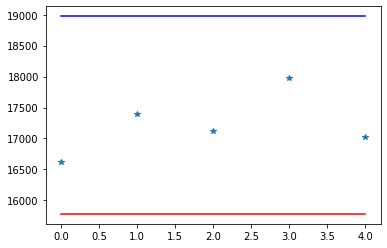

best gap with NN 20.25% on 1 tial,
with a total time of 0.005 seconds
best gap with random + 2opt 5.35% on 5 tials,
with a total time of 5.05 seconds


In [3]:
import numpy as np
from time import time as t
import matplotlib.pyplot as plt


from AI2020.solvers.local_search import TwoOpt
from AI2020.solvers.TSP_solver import Solver_TSP
from AI2020.solvers.constructive_algorithms import random_initializer, nearest_neighbor
# if you are running from your local remove the prefix AI2020 (comment the previous 3 line and uncomment the following 3 line)
# from solvers.local_search import TwoOpt
# from solvers.TSP_solver import Solver_TSP
# from solvers.constructive_algorithms import random_initializer, nearest_neighbor

def my_local_search(solution, cost_sol, dist_matrix):
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix): 
    new_solution, new_cost, numbert_calls_LS, ending_cond = data
    yield  new_solution, new_cost, numbert_calls_LS, ending_cond

number_of_trials = 5
found_lens = []
start = t()
solver = Solver_TSP(('random', random_initializer.random_method))
solver.bind(('my local search', my_local_search ))

for _ in range(number_of_trials):
  solver(ic)
  found_lens.append(solver.found_length)
end = t()

solver = Solver_TSP(('nearest neighbor', nearest_neighbor.nn))
solver(ic)

plt.plot(found_lens, "*")
plt.plot(np.ones(number_of_trials)*ic.best_sol, "r-")
plt.plot(np.ones(number_of_trials)*solver.found_length, "b-")
plt.show()
print(f"best gap with NN {solver.gap}% on 1 tial,\nwith a total time of {np.round(solver.time_to_solve, 5)} seconds")
print(f"best gap with random + 2opt {np.round(100*(min(found_lens) - ic.best_sol)/ic.best_sol, 2)}% on {number_of_trials} tials,\nwith a total time of {np.round(end - start, 2)} seconds")


## Double Bridge

Here you need to implement your own Double Bridge permutation!

In [4]:
class DoubleBridge:
  
  @staticmethod
  def difference_cost(solution, a, b, c, d, matrix):
    n = matrix.shape[0]
    to_remove = matrix[solution[a-1], solution[a]] + matrix[solution[b-1], solution[b]] + matrix[solution[c-1], solution[c]] + matrix[solution[d-1], solution[d]]
    to_add = matrix[solution[a], solution[c-1]] + matrix[solution[b], solution[d-1]] + matrix[solution[c], solution[a-1]] + matrix[solution[d], solution[b-1]]
    return to_add - to_remove


  @staticmethod
  def perturbate_solution(solution, actual_cost, matrix):
    a, b, c, d = np.sort(np.random.choice(matrix.shape[0], size=4))
    # print(a,b,c,d)
    A = solution[a:b]
    B = solution[b:c]
    C = solution[c:d]
    D = np.concatenate((solution[d:],solution[:a]))
    new_solution = np.concatenate((D,C,B,A))
    new_length = actual_cost + DoubleBridge.difference_cost(solution, a, b, c, d, matrix)
    return new_solution, new_length

In [5]:
from AI2020.solvers.constructive_algorithms import compute_lenght

# example perturbation
case_solution = np.arange(12)
matrix = np.random.rand(12, 12)
cost = compute_lenght(case_solution, matrix)
print(case_solution, cost)

new_sol, new_lenght = DoubleBridge.perturbate_solution(case_solution, cost, matrix)
print(new_sol, new_lenght)

[ 0  1  2  3  4  5  6  7  8  9 10 11] 6.006859891058449
[11  8  9 10  6  7  0  1  2  3  4  5] 4.912777343357247


## Iterated Local Search


Here you need to implement the three variants of the ILS we saw in class

In [44]:
cost_sol_better = []
cost_sol_RW = []
cost_sol_LSMC = []


def my_local_search(solution, cost_sol, dist_matrix):
  new_solution, new_cost = solution, cost_sol
  for data in TwoOpt.local_search(solution, cost_sol, dist_matrix): 
    new_solution, new_cost, numbert_calls_LS, ending_cond = data
  return new_solution, new_cost


class ILS_better:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_better
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_better.append(new_cost)
    calls = 0
    while True:  
      calls += 1
      new_sol, new_cost = DoubleBridge.perturbate_solution(best_sol, best_cost, matrix)
      new_sol, new_cost = my_local_search(new_sol, new_cost, matrix)
      cost_sol_better.append(new_cost)
      if new_cost < best_cost:
        best_sol, best_cost = new_sol, new_cost

      yield best_sol, best_cost, calls, False
      

class ILS_RW:
  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_RW
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_RW.append(new_cost)
    calls = 0
    while True:  
      calls += 1
      new_sol, new_cost = DoubleBridge.perturbate_solution(best_sol, best_cost, matrix)
      best_sol, best_cost = my_local_search(new_sol, new_cost, matrix)
      cost_sol_RW.append(best_cost)
      yield best_sol, best_cost, calls, False

class ILS_LSMC:
  @staticmethod
  def acceptance_criterion(best_cost, new_cost, temperature):
    if new_cost < best_cost:
      return True
    else:  
      alpha = np.random.rand(1)
      prob = np.exp((best_cost - new_cost)/temperature)
      if alpha<= prob:
        return True
      else:
        return False

  @staticmethod
  def solve(solution, actual_cost, matrix):
    global cost_sol_better
    new_sol, new_cost = my_local_search(solution, actual_cost, matrix)
    best_sol,best_cost = new_sol, new_cost
    cost_sol_LSMC.append(new_cost)
    calls = 0
    temperature = new_cost
    decrease = 0.95
    while True:  
      calls += 1
      new_sol, new_cost = DoubleBridge.perturbate_solution(best_sol, best_cost, matrix)
      new_sol, new_cost = my_local_search(new_sol, new_cost, matrix)
      cost_sol_LSMC.append(new_cost)
      if ILS_LSMC.acceptance_criterion(best_cost, new_cost, temperature):
        best_sol, best_cost = new_sol, new_cost

      temperature *= decrease
      yield best_sol, best_cost, calls, False

### Example of Table

Take care that you need to change the code in order to satisfy the requirements for the task! 

In [ ]:
import pandas as pd

seeds= [0]
time_to_solve = 180 # in seconds

names_instances = ["d198.tsp"] #, "pr439.tsp", "u1060.tsp" 
samples = {name:{} for name in names_instances}
collectors = [cost_sol_better, cost_sol_RW, cost_sol_LSMC]
initializers = ["random"] 
init_functions = [random_initializer.random_method]
improvements = ["ILS-better","ILS-RW","ILS-LSMC"]
improve_functions = [ILS_better.solve, ILS_RW.solve, ILS_LSMC.solve]
results = []
index = []
for s_ in seeds:
  for i, init in enumerate(initializers):
    for j, improve in enumerate(improvements):
      solver = Solver_TSP((init, init_functions[i]), seed_=s_, stop_run_after=time_to_solve)
      solver.bind((improve, improve_functions[j]))
      for name in names_instances:
        instance = TSP_Instance_Creator("standard", name)
        solver(instance)
        index.append((name, instance.best_sol, solver.name_method, s_))
        results.append([solver.found_length, solver.gap, solver.time_to_solve, solver.ls_calls])
        samples[name][improve] = np.round(np.abs(np.array(collectors[j]) - ic.best_sol)/ic.best_sol * 100, 2) 
        # if j == 0:
        #   cost_sol_better = []
        # elif j == 1:
        #   cost_sol_RW = []
        # else:
        #   cost_sol_LSMC = []
  
          

index = pd.MultiIndex.from_tuples(index, names=['problem','optimal lenght', 'method', 'seed'])

pd.DataFrame(results, index=index, columns=["tour length", "gap", "time to solve", "calls Local Search"])

In [ ]:
import warnings
import seaborn as sns

with warnings.catch_warnings():
  warnings.simplefilter("ignore")    
  for instance in names_instances:
    fig = plt.figure(figsize=(10,6))
    for j, improve in enumerate(improvements):
      sns.distplot(samples[instance][improve], rug=True, hist=False)
    
    fig.legend(labels=improvements)
    plt.title(instance)
    plt.show()
